In [1]:
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype import DataGrabber, DataSink, IdentityInterface
from nipype.interfaces.utility import Function
import nipype.interfaces.fsl as fsl
import nipype.interfaces.ants as ants
from nipype.algorithms.misc import Gunzip
import nipype.interfaces.spm as spm
import nipype.interfaces.matlab as mlab
from nipype.interfaces.utility import Merge
import os
from IPython.display import Image
#from nilearn import plotting
#import pydot
import glob
%matplotlib inline 

220422-19:15:33,519 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.7.0


In [2]:
from modules import antsRegistrationSyn as antsreg

In [3]:
base_dir = '/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/PhysStroke_TorstenRackoll'

T1_dir =  os.path.join(base_dir, 'T1')

flairs_dir = os.path.join(base_dir, 'FLAIR')
lesions_dir = os.path.join(base_dir, 'Lesions')

#wdir = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/Phys-Stroke'
wdir = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/ANTs-Pipeline'
tmp_dir = os.path.join(wdir, 'tmp')
out_dir = os.path.join(wdir, 'out')


## Settings
cores = 4 # How many cores do we wanna use?
fsl.FSLCommand.set_default_output_type('NIFTI_GZ') # fsl output format

In [4]:
in_files = glob.glob(base_dir + '/T1/[0-9][0-9][0-9]_[BL V1]*.nii')
#sub_ids = [x.split('/')[-1][:9] for x in in_files]
sub_ids = [x.split('/')[-1][:6] for x in in_files]
', '.join(sub_ids)

''

In [5]:
#subject_list = sub_ids[:2] # for testing
subject_list = sub_ids

In [6]:
# 301
subject_list = [ '601_V1']

In [7]:
infosource = Node(interface=IdentityInterface(fields=['subject_id']), name='infosource')
infosource.iterables = ('subject_id', subject_list)

info = dict(t1=[['T1', 'subject_id', 'T1.nii.gz']],
            flair=[['test', 'subject_id', 'FLAIR.nii.gz']],
           lesion=[['test', 'subject_id', 'FLAIR_KV.nii.gz']])

#templates = dict(t1=[['%s/%s_%s']],
#                flair=[['%s/%s_%s']],
#                lesion=[['%s/%s_%s']],
#                mni152=[['%s']])

datasource = Node(interface=DataGrabber(infields=['subject_id'], 
                                          outfields=['t1', 'flair', 'lesion']),
                   name ='data_grabber')
datasource.inputs.base_directory = wdir
datasource.inputs.template = '%s/%s_%s'
#datasource.inputs.template = templates
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True

refsource = Node(interface=DataGrabber(outfields=['mni152']), name = 'refsource')
refsource.inputs.base_directory = '/usr/share/data/fsl-mni152-templates/'
refsource.inputs.template = 'MNI152_T1_1mm.nii.gz'
refsource.inputs.sort_filelist = True

lesionssource = Node(interface=DataGrabber(infields = ['subject_id'], 
                                           outfields=['lesion']),
                     name = 'lesionssource')
lesionssource.inputs.base_directory = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/Lesion_Analysis/Lesion_masks/Final/'
lesionssource.inputs.template = '%s_FLAIR_KV.nii'
lesionssource.inputs.template_args = dict(lesion=[['subject_id']])
lesionssource.inputs.sort_filelist = True

TraitError: The 'base_directory' trait of a DataGrabberInputSpec instance must be a pathlike object or string representing an existing directory, but a value of '/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/ANTs-Pipeline' <class 'str'> was specified.

In [9]:
ro_t1 = Node(interface=fsl.Reorient2Std(), name='ro_t1')
ro_flair = Node(interface=fsl.Reorient2Std(), name='ro_ro_flair')

antsreg_flair2t1 = Node(interface=antsreg.RegistrationSyN(dimension = 3,
                                                   transform_type = 'r',
                                                   use_histogram_matching = True), 
                      name = 'antsreg_flair2t1')

antstransform_les2t1 = Node(interface=ants.ApplyTransforms(), name='antstransform_les2t1')

antstransform_flair2t1 = Node(interface=ants.ApplyTransforms(), name='antstransform_flair2t1')


In [10]:
binarize_lesion = Node(interface=fsl.UnaryMaths(operation = 'bin'),
                      name = 'binarize_lesion')

In [11]:
# SPM Segment with Bias Field Correction
gunzip_norm_t1 = Node(interface=Gunzip(), name='gunzip_norm_t1')
seg_norm_t1 = Node(interface=spm.NewSegment(channel_info=(0.0001, 60, 
                                                          (True, True))), 
                   name="seg_norm_t1")


stty: 'standard input': Inappropriate ioctl for device


In [12]:
sink = Node(interface=DataSink(),
                   name='sink')
sink.inputs.base_directory = out_dir
sink.inputs.substitutions = [('_subject_id_', '')]
#sink.inputs.regexp_substitutions = [('_\w+\d+', '.')]

In [13]:
main = Workflow(name='main', base_dir = tmp_dir)
main.connect(infosource, 'subject_id', datasource, 'subject_id')
main.connect(datasource, 't1', ro_t1, 'in_file')
main.connect(datasource, 'flair', ro_flair, 'in_file')
main.connect(ro_t1, 'out_file', antsreg_flair2t1, 'fixed_image')
main.connect(ro_flair, 'out_file', antsreg_flair2t1, 'moving_image')
#main.connect(datasource, 't1', antsreg_les2t1, 'reference_image')

main.connect(datasource, 'lesion', antstransform_les2t1, 'input_image')
main.connect(antsreg_flair2t1, 'out_matrix', antstransform_les2t1, 'transforms')
main.connect(ro_t1, 'out_file', antstransform_les2t1, 'reference_image')


main.connect(ro_flair, 'out_file', antstransform_flair2t1, 'input_image')
main.connect(antsreg_flair2t1, 'out_matrix', antstransform_flair2t1, 'transforms')
main.connect(ro_t1, 'out_file', antstransform_flair2t1, 'reference_image')


main.connect(binarize_lesion, 'out_file', sink, '@les2t12mni')

ImportError: cannot import name 'gcd' from 'fractions' (/home/orco/anaconda3/envs/wmhpype_cpu/lib/python3.9/fractions.py)

In [ ]:

main.connect(gunzip_norm_t1, 'out_file', seg_norm_t1, 'channel_files')
main.connect(seg_norm_t1, 'native_class_images', sink, '@tissues')

In [ ]:
#Importing other workflows
from modules.skullstripping import *
from modules.seg_fast import *
main.connect(antstransform_t12mni, 'output_image', skull_stripping, 'conv_mgz.in_file')
main.connect(skull_stripping, 'bet.out_file', sink, '@brain')
main.connect(skull_stripping, 'bet.mask_file', sink, '@mask')
main.connect(skull_stripping, 'bet.out_file', fast, 'in_files')
main.connect(fast, 'tissue_class_files', sink, '@seg')
main.connect(fast, 'partial_volume_files', sink, '@vol')

In [ ]:
#main.connect(t1_norm, 'out_file', skull_stripping, 'conv_mgz.in_file')
#main.connect(skull_stripping, 'bet.out_file', sink, '@brain')
#main.connect(skull_stripping, 'bet.mask_file', sink, '@mask')
#main.connect(skull_stripping, 'bet.out_file', fast, 'in_files')
#main.connect(fast, 'tissue_class_files', sink, '@seg')
#main.connect(fast, 'partial_volume_files', sink, '@vol')

In [ ]:
main.write_graph(graph2use='colored', dotfilename='./main_graph')
Image(filename='main_graph.png')

In [16]:
cores = 1
main.run('MultiProc', plugin_args={'n_procs': cores})

190826-17:40:40,46 nipype.workflow INFO:
	 Workflow main settings: ['check', 'execution', 'logging', 'monitoring']
190826-17:40:40,401 nipype.workflow INFO:
	 Running in parallel.
190826-17:40:40,411 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.95/13.95, Free processors: 1/1.
190826-17:40:40,521 nipype.workflow INFO:
	 [Node] Setting-up "main.data_grabber" in "/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/ANTs-Pipeline/tmp/main/_subject_id_601_V1/data_grabber".
190826-17:40:40,687 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
190826-17:40:40,817 nipype.workflow INFO:
	 [Node] Finished "main.data_grabber".
190826-17:40:42,412 nipype.workflow INFO:
	 [Job 0] Completed (main.data_grabber).
190826-17:40:42,422 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.95/13.95, Free processors: 1/1.
190826-17:40:42,559 nipype.workflow INFO:
	 [Node] Sett

RuntimeError: Workflow did not execute cleanly. Check log for details

In [17]:
# Apply mask

In [23]:
subs = os.listdir(out_dir)
subs

['217_BL',
 '221_BL',
 '221_V1',
 '301_BL',
 '301_V1',
 '302_BL',
 '302_V1',
 '303_V1',
 '305_BL',
 '307_BL',
 '308_BL',
 '308_V1',
 '309_BL',
 '309_V1',
 '311_BL',
 '311_V1',
 '312_BL',
 '312_V1',
 '313_BL',
 '315_BL',
 '315_V1',
 '316_BL',
 '316_V1',
 '318_BL',
 '319_BL',
 '319_V1',
 '321_BL',
 '321_V1',
 '322_BL',
 '322_V1',
 '323_BL',
 '326_BL',
 '326_V1',
 '327_BL',
 '330_BL',
 '330_V1',
 '331_BL',
 '402_BL',
 '402_V1',
 '403_BL',
 '403_V1',
 '405_BL',
 '406_BL',
 '408_BL',
 '408_V1',
 '410_BL',
 '410_V1',
 '414_BL',
 '414_V1',
 '415_BL',
 '415_V1',
 '601_BL',
 '602_BL',
 '604_BL',
 '604_V1',
 '605_BL',
 '606_BL',
 '606_V1',
 '607_BL',
 '608_BL',
 '608_V1',
 '611_BL',
 '611_V1',
 '612_BL',
 '613_V1',
 '614_BL',
 '614_V1',
 '617_BL',
 '617_V1',
 '618_BL',
 '618_V1',
 '619_BL',
 '619_V1',
 '621_BL',
 '621_V1',
 '623_BL',
 '623_V1',
 '624_BL',
 '624_V1',
 '626_BL',
 '626_V1',
 '627_BL',
 '627_V1',
 '628_BL',
 '628_V1',
 '629_V1',
 '633_BL',
 '633_V1',
 '635_BL',
 '635_V1',
 '636_BL',

In [24]:
infosource = Node(interface=IdentityInterface(fields=['subject_id']), name='infosource')
infosource.iterables = ('subject_id', subs)

info = dict(csf=[['subject_id','', 'brainmask.auto_out_brain_pve_0.nii.gz']],
            gm=[['subject_id','', 'brainmask.auto_out_brain_pve_1.nii.gz']],
           wm=[['subject_id','', 'brainmask.auto_out_brain_pve_2.nii.gz']],
           les=[['subject_id', 'subject_id', '_FLAIR_KV_trans_trans_bin.nii.gz']])

#templates = dict(t1=[['%s/%s_%s']],
#                flair=[['%s/%s_%s']],
#                lesion=[['%s/%s_%s']],
#                mni152=[['%s']])

datasource = Node(interface=DataGrabber(infields=['subject_id'], 
                                          outfields=['t1', 'flair', 'lesion']),
                   name ='data_grabber')
datasource.inputs.base_directory = out_dir
datasource.inputs.template = '%s/%s%s'
#datasource.inputs.template = templates
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True

In [25]:
sink = Node(interface=DataSink(),
                   name='sink')
sink.inputs.base_directory = out_dir
sink.inputs.substitutions = [('_subject_id_', '')]
#sink.inputs.regexp_substitutions = [('_\w+\d+', '.')]

In [26]:
apply_to_csf = Node(interface=fsl.BinaryMaths(operation='mul'), name='apply_to_csf')
apply_to_wm = Node(interface=fsl.BinaryMaths(operation='mul'), name='apply_to_wm')
apply_to_gm = Node(interface=fsl.BinaryMaths(operation='mul'), name='apply_to_gm')
inv_les = Node(interface=fsl.UnaryMaths(operation='binv'), name='inv_les')


apply_mask = Workflow(name='apply_mask', base_dir = tmp_dir)
apply_mask.connect(infosource, 'subject_id', datasource, 'subject_id')

apply_mask.connect(datasource, 'csf', apply_to_csf, 'in_file')
apply_mask.connect(datasource, 'wm', apply_to_wm, 'in_file')
apply_mask.connect(datasource, 'gm', apply_to_gm, 'in_file')
apply_mask.connect(datasource, 'les', inv_les, 'in_file')

apply_mask.connect(inv_les, 'out_file', apply_to_csf, 'operand_file')
apply_mask.connect(inv_les, 'out_file', apply_to_wm, 'operand_file')
apply_mask.connect(inv_les, 'out_file', apply_to_gm, 'operand_file')

apply_mask.connect(apply_to_csf, 'out_file', sink, '@csf')
apply_mask.connect(apply_to_wm, 'out_file', sink, '@wm')
apply_mask.connect(apply_to_gm, 'out_file', sink, '@gm')

200617-17:37:18,504 nipype.workflow INFO:
	 Generated workflow graph: ./apply_mask.png (graph2use=colored, simple_form=True).


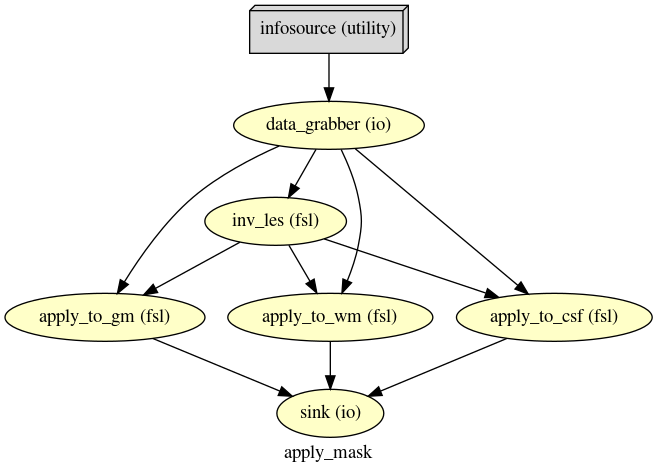

In [27]:
apply_mask.write_graph(graph2use='colored', dotfilename='./apply_mask')
Image(filename='apply_mask.png')

In [28]:
cores = 8
apply_mask.run('MultiProc', plugin_args={'n_procs': cores})

200617-17:37:19,873 nipype.workflow INFO:
	 Workflow apply_mask settings: ['check', 'execution', 'logging', 'monitoring']
200617-17:37:21,936 nipype.workflow INFO:
	 Running in parallel.
200617-17:37:21,962 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 173 jobs ready. Free memory (GB): 28.20/28.20, Free processors: 8/8.
200617-17:37:22,62 nipype.workflow INFO:
	 [Node] Setting-up "apply_mask.data_grabber" in "/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/ANTs-Pipeline/tmp/apply_mask/_subject_id_814_V1/data_grabber".
200617-17:37:22,72 nipype.workflow INFO:
	 [Node] Setting-up "apply_mask.data_grabber" in "/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/ANTs-Pipeline/tmp/apply_mask/_subject_id_813_V1/data_grabber".
200617-17:37:22,86 nipype.workflow INFO:
	 [Node] Setting-up "apply_mask.data_grabber" in "/media/drive_s/AG/AG-Floeel-Imaging/02-User/TorstenRackoll/ANTs-Pipeline/tmp/apply_mask/_subject_id_813_BL/data_grabber".
200617-17:37:22,99 nipype.wo